In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import trange, tqdm, notebook
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import itertools
import sys
sys.path.append(os.path.abspath('../scripts'))
from my_utilities import *

In [2]:
data_path_base = r"../data/"

In [3]:
ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))
ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [4]:
ODdf

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd
trip_id,,,,,,,,
1000007,26798.0,0.684278,0.570806,0.0,26804.0,0.685274,0.571578,9.74
1000011,23414.0,0.505815,0.250499,0.0,23417.0,0.505366,0.250347,6.08
1000015,23689.0,0.554151,0.161940,0.0,23734.0,0.554292,0.161518,10.15
1000020,26928.0,0.389398,0.389645,0.0,26935.0,0.390773,0.390996,13.07
1000024,25380.0,0.420249,0.567624,0.0,25396.0,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
73013,29902.0,0.804917,0.152156,0.0,29903.0,0.804919,0.152085,2.20
732987,35788.0,0.368885,0.342547,0.0,35792.0,0.369623,0.342151,8.16
734746,27918.0,0.353437,0.634457,0.0,27926.0,0.355882,0.634051,12.66


In [5]:
tmin = ODdf['orig time'].min()
tmax = ODdf['dest time'].max()

In [6]:
ODdf['orig time'] -= tmin
ODdf['orig time'] /= tmax
ODdf['dest time'] -= tmin
ODdf['dest time'] /= tmax

In [7]:
ODdf

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd
trip_id,,,,,,,,
1000007,0.145421,0.684278,0.570806,0.0,0.145588,0.685274,0.571578,9.74
1000011,0.051274,0.505815,0.250499,0.0,0.051358,0.505366,0.250347,6.08
1000015,0.058925,0.554151,0.161940,0.0,0.060177,0.554292,0.161518,10.15
1000020,0.149037,0.389398,0.389645,0.0,0.149232,0.390773,0.390996,13.07
1000024,0.105970,0.420249,0.567624,0.0,0.106416,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
73013,0.231777,0.804917,0.152156,0.0,0.231805,0.804919,0.152085,2.20
732987,0.395532,0.368885,0.342547,0.0,0.395643,0.369623,0.342151,8.16
734746,0.176580,0.353437,0.634457,0.0,0.176803,0.355882,0.634051,12.66


#### Parameters

In [8]:
spatial_threshold = 0.035 #area is roughly 20x20km so roughly 28km is the diameter so 0.035 * 28km = 1 km

time_threshold = 600/(tmax - tmin) #600 seconds

w_t = 0.5
w_x = 1 - w_t

##### We get a sample of  size 20000 rides to match.

In [9]:
ridersDF = ODdf.sample(n=20000,random_state=1234)

ridesDF = ODdf[~ ODdf.index.isin(ridersDF.index)]

# reqDF = otherDF.sample(n=2000,random_state=1234)

In [10]:
ridersDF

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd
trip_id,,,,,,,,
1086458,0.157940,0.851826,0.212828,0.0,0.158051,0.851750,0.212210,7.940000
1384942,0.056393,0.358746,0.474148,0.0,0.056449,0.358929,0.474337,4.930000
1333980,0.213777,0.432013,0.445753,0.0,0.214111,0.433421,0.443710,10.970000
1457610,0.303889,0.596405,0.575477,0.0,0.303973,0.596781,0.575750,6.230000
1090549,0.096734,0.158854,0.704734,0.0,0.096762,0.158928,0.704699,2.130000
...,...,...,...,...,...,...,...,...
1068489,0.044625,0.323014,0.507674,0.0,0.044764,0.322543,0.506821,9.460000
1059871,0.352270,0.867736,0.092523,0.0,0.352326,0.867652,0.092723,4.240000
1479067,0.129006,0.340803,0.455770,0.0,0.129451,0.338729,0.456699,0.000000


In [11]:
ridesDF

,orig time,orig x,orig y,orig spd,dest time,dest x,dest y,dest spd
trip_id,,,,,,,,
1000007,0.145421,0.684278,0.570806,0.0,0.145588,0.685274,0.571578,9.74
1000011,0.051274,0.505815,0.250499,0.0,0.051358,0.505366,0.250347,6.08
1000015,0.058925,0.554151,0.161940,0.0,0.060177,0.554292,0.161518,10.15
1000020,0.149037,0.389398,0.389645,0.0,0.149232,0.390773,0.390996,13.07
1000024,0.105970,0.420249,0.567624,0.0,0.106416,0.421578,0.562920,8.20
...,...,...,...,...,...,...,...,...
73013,0.231777,0.804917,0.152156,0.0,0.231805,0.804919,0.152085,2.20
732987,0.395532,0.368885,0.342547,0.0,0.395643,0.369623,0.342151,8.16
734746,0.176580,0.353437,0.634457,0.0,0.176803,0.355882,0.634051,12.66


#### Carpooling scenario
The ride has to be started before and end before meaning they will pick someone up and drop them off first before going to final destination!

In [12]:
notebook.tqdm.pandas()

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [13]:
def threshold_filter_trips_carpool(ridesDF, start_time, start_x, start_y, end_time, end_x, end_y, time_threshold, space_threshold):
    
    #ride must be after rider in pick up
    ridesDF = ridesDF[ ((start_time - ridesDF['orig time'] >= 0) & (start_time - ridesDF['orig time'] <= time_threshold)) &
                       ((ridesDF['dest time'] - end_time   >= 0) & (ridesDF['dest time'] - end_time   <= time_threshold)) ]
    #ride must be before rider for drop off    
    
    OO_distance = np.sqrt( (ridesDF['orig x'] - start_x) ** 2 + (ridesDF['orig y'] - start_y)**2 )
    DD_distance = np.sqrt( (ridesDF['dest x'] - end_x) ** 2 + (ridesDF['dest y'] - end_y)**2 )
    
    ridesDF = ridesDF[(OO_distance <= space_threshold) & (DD_distance <= space_threshold)]
    
    if not ridesDF.empty:
        return ridesDF.index.values    
    

In [14]:
candidate_stats_per_thresh_multiplier = []
candidates_per_thresh_multiplier = []
for i in range(1,6):
    t_thresh = time_threshold * i
    s_thresh = spatial_threshold * i
    candidates = ridersDF.progress_apply(lambda row: threshold_filter_trips_carpool(ridesDF, row[0], row[1], row[2], row[4], row[5], row[6], t_thresh, s_thresh),axis=1)
    len_candidates = candidates.apply(lambda x: len(x) if x is not None else 0)
    candidate_stats_per_thresh_multiplier.append((i,len_candidates.describe()))
    candidates_per_thresh_multiplier.append((i,candidates))

In [15]:
candidate_stats_per_thresh_multiplier

[(1, count    20000.000000
  mean         1.174250
  std          1.615617
  min          0.000000
  25%          0.000000
  50%          1.000000
  75%          2.000000
  max         18.000000
  dtype: float64), (2, count    20000.00000
  mean         3.92625
  std          4.25226
  min          0.00000
  25%          1.00000
  50%          3.00000
  75%          6.00000
  max         34.00000
  dtype: float64), (3, count    20000.000000
  mean         8.219650
  std          8.139866
  min          0.000000
  25%          2.000000
  50%          6.000000
  75%         12.000000
  max         58.000000
  dtype: float64), (4, count    20000.000000
  mean        13.590150
  std         12.933601
  min          0.000000
  25%          4.000000
  50%         10.000000
  75%         20.000000
  max         87.000000
  dtype: float64), (5, count    20000.000000
  mean        20.023050
  std         18.617216
  min          0.000000
  25%          6.000000
  50%         14.000000
  75%    

In [17]:
L = 4
for mult,candidates in candidates_per_thresh_multiplier:
    print(np.sum(candidates.apply(lambda x: len(x) >= L if x is not None else False)))

1752
8041
12862
15313
16773


In [22]:

for mult, candidate in candidates_per_thresh_multiplier:
    candidate.to_csv('threshold_mult_{}_candidate_matches.csv'.format(mult))

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


#### Loop below uses the found candidates and wgm function to find best four matches.

In [24]:
_,candidates = candidates_per_thresh_multiplier[2]

best_matches_per_ride = [] #stores (trip_id, pandas.series) where the series index our the matched trip ids and the values are similarity score
for trip_id, trip in notebook.tqdm(ridersDF.iterrows(),total=len(ridersDF)):
    current_candidates = candidates[trip_id]
    if current_candidates is None or len(current_candidates) < 4:
        best_matches_per_ride.append( (trip_id,None))
        continue 
    candidateDF = ridesDF.loc[current_candidates,:]
    scores = candidateDF.apply(lambda x: get_trip_similarity_wgm(trip.values, x.values, w_t, w_x),axis=1)
    best_matches_per_ride.append( (trip_id,scores.sort_values(ascending=False)[:4]))

In [25]:
best_matches_per_ride[:2]

[('1086458', trip_id
  120660     0.993438
  238948     0.985508
  1071074    0.985188
  1057665    0.977543
  dtype: float64), ('1384942', trip_id
  114596     0.992703
  1193767    0.988248
  1340879    0.987817
  110107     0.985751
  dtype: float64)]

### Now let's measure performance

In [26]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, r"koln_morning_dataframe.parquet"))

In [27]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
# tmax1 = morningdf_no_nan.time.max()
# tmin1 = morningdf_no_nan.time.min()

In [28]:
del morningdf_no_nan

LoL! Just needed it for the scaling factors :|

#### The important measure is how much they go out of their way comparing to the part where they carpool

In [186]:
xyt_columns = ['orig time','orig x','orig y','dest time','dest x','dest y']

In [30]:
total_travel_needed_by_riders = np.sqrt( np.square(ridersDF['orig x'] - ridersDF['dest x']) + np.square(ridersDF['orig y'] - ridersDF['dest y']) ) 

Counting km needed 

In [50]:
km_needed = np.int64(0)
km_traveled = np.int64(0)

km_needed = np.sum(np.sqrt((ongoingDF.x_begin - ongoingDF.x_end)**2 + (ongoingDF.y_begin - ongoingDF.y_end)**2))
km_needed += np.sum(np.sqrt((reqDF.x_begin - reqDF.x_end)**2 + (reqDF.y_begin - reqDF.y_end)**2))

In [51]:
for req , matches in results:
    
    req_od = np.sqrt( (req[2] - req[6]) ** 2 + (req[3] - req[7])**2 )
    
    if(type(matches) is list): #that is if there was no match, it has to travel completely! so nothing is saved
        km_traveled += req_od
        continue
    
    m = matches[:1]

    oo = np.sqrt( (req[2] - m.x_begin)**2 + (req[3] - m.y_begin)**2 ).values[0]
    m_od = np.sqrt((m.x_begin - m.x_end)**2 + (m.y_begin - m.y_end)**2).values[0]
    dd = np.sqrt((m.x_end - req[6])**2 + (m.y_end - req[7])**2).values[0] 
    
    km_traveled += oo + dd + req_od

There are some rides that don't pick up anyone!

In [52]:
no_passenger_rides = ongoingDF[~ ongoingDF.index.isin(ongoing_counts.keys())]

In [53]:
km_traveled += np.sum(np.sqrt((no_passenger_rides.x_begin - no_passenger_rides.x_end)**2 + (no_passenger_rides.y_begin - no_passenger_rides.y_end)**2))

In [54]:
km_traveled, km_needed, km_traveled / km_needed

(50836363.678376213, 52500659.573500894, 0.96829952406988973)

#### Let's just count only those that have a match and see if they don't carpool how much is used vs if they do!

In [61]:
km_needed = np.int64(0)
km_traveled = np.int64(0)

In [62]:
for req , matches in results:
    
    if(type(matches) is list): #that is if there was no match, it has to travel completely! so nothing is saved
        continue
    
    m = matches[:1]

    req_od = np.sqrt( (req[2] - req[6]) ** 2 + (req[3] - req[7])**2 )
    oo = np.sqrt( (req[2] - m.x_begin)**2 + (req[3] - m.y_begin)**2 ).values[0]
    m_od = np.sqrt((m.x_begin - m.x_end)**2 + (m.y_begin - m.y_end)**2).values[0]
    dd = np.sqrt((m.x_end - req[6])**2 + (m.y_end - req[7])**2).values[0] 
    
    km_traveled += oo + dd + req_od
    km_needed += req_od + m_od

In [63]:
km_traveled, km_needed, km_traveled / km_needed

(5025579.090945662, 7031415.6343580466, 0.71473218940277972)

#### Let's get the distribution for trip distances and times

In [64]:
import seaborn as sns

In [65]:
ongoing_distances = np.sqrt((ongoingDF.x_begin - ongoingDF.x_end)**2 + (ongoingDF.y_begin - ongoingDF.y_end)**2)
req_distances = np.sqrt((reqDF.x_begin - reqDF.x_end)**2 + (reqDF.y_begin - reqDF.y_end)**2)
ongoing_time = ongoingDF.time_end - ongoingDF.time_begin
req_time = reqDF.time_end - reqDF.time_begin

In [93]:
cdf_args = dict(hist=False,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))

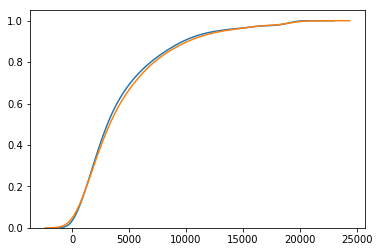

In [96]:
# plt.subplot(121)
sns.distplot(ongoing_distances,**cdf_args)
# plt.subplot(122)
sns.distplot(req_distances,**cdf_args)
plt.gcf().set_size_inches(6, 4, forward=True)


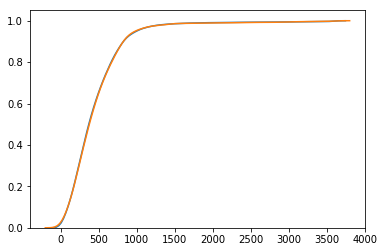

In [97]:
# plt.subplot(121)
sns.distplot(ongoing_time,**cdf_args)
# plt.subplot(122)
sns.distplot(req_time,**cdf_args)
plt.gcf().set_size_inches(6, 4, forward=True)

In [ ]:
sns.c